## Projeto Redes Neurais 

Utilizando a arquitetura de Deep Learning LSTM para prever série temporal. 

### Notebook com o otimizador SGD, o número de recorrência é de 48, duas camadas DENSE, e 700 épocas para treino. 

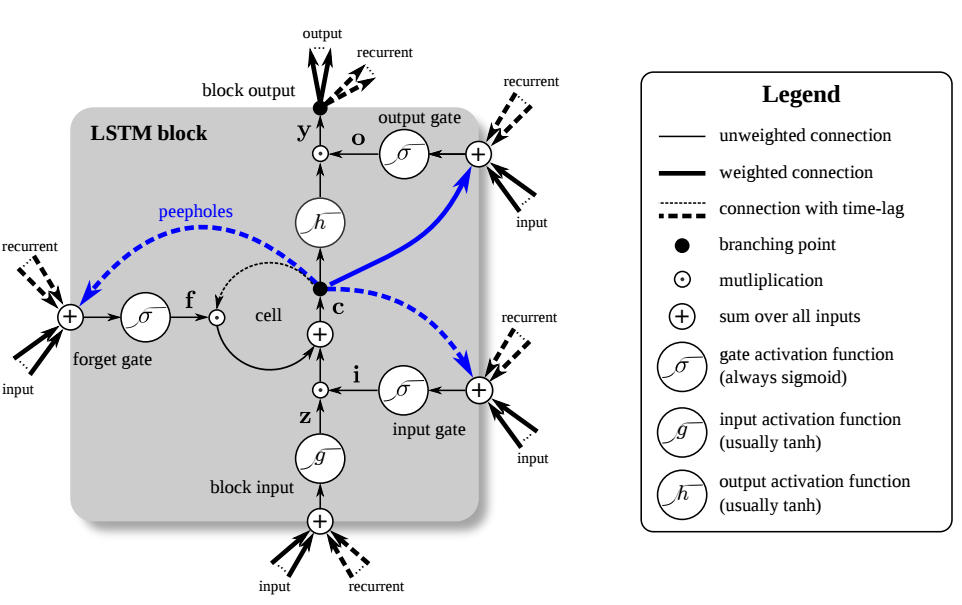

In [1]:
# Importando bibliotecas

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
numpy.random.seed(7)

## Carregando a base de dados e analisando a estrutura da série temporal.

In [2]:
# Carrega apenas a coluna com o total de doentes por mês 

dataframe = pandas.read_csv('ldeaths.csv', usecols=[1], engine='python', skipfooter=3, sep = ',')
dataframe.head(3)

,value
0,3035
1,2552
2,2704


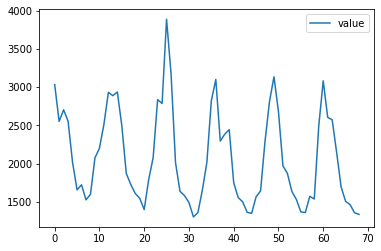

In [3]:
dataframe.plot()

## Ajustar a escala dos dados entre 0 e 1 e divide a base de dados entre treino (67% primeiros meses) e testes (33% dos meses finais da série).

In [4]:
#Converte a coluna do dataframe pandas em um vetor numpy

dataset = dataframe.values
dataset = dataset.astype('float32')

look_back = 12

# Divite os dados de treino (2/3) e teste (1/3)
# Note que a divisão não é aleatória, mas sim sequencial

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back-1:len(dataset),:]

## Criação dos pares de dados $X$ e $Y$, onde $Y_{t} = X_{t-1}$ (para look_bak=1). Uma outra forma de pensar no valor de $Y$ para um dado $X$ é que ele é o próximo $X$ na série temporal.

In [5]:
# Recebe uma série e converte em uma matriz com séries deslocadas.

def create_dataset(dataset, look_back=1, std=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]-dataset[i, 0]
        a /= std
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]-dataset[i + look_back-1, 0])
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
std = train[:, 0].std()
trainX, trainY = create_dataset(train, look_back, std)
testX, testY = create_dataset(test, look_back, std)

# shape is [samples, time steps, features]
trainX = trainX.reshape(-1, look_back, 1)
testX = testX.reshape(-1, look_back, 1)
trainY = trainY / 30
testY = testY / 30

trainX.shape, testX.shape

((34, 12, 1), (24, 12, 1))

##	Criação de uma rede LSTM contendo mais uma camada DENSE, as 48 recorrências, o otimizador SGD, pois essa configuração apresentou melhor valor de RMSE.

In [6]:
"""É nesse trecho de código temos o otimizador SGD, 48 recorrências e a adição
de outra camada DENSE."""

model = Sequential()
model.add(LSTM(48, input_shape=(look_back, 1), return_sequences=False))
model.add(Dropout(0.2))
#model.add(LSTM(32, return_sequences=False)) 
model.add(Dense(1))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48)                9600      
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 9,651
Trainable params: 9,651
Non-trainable params: 0
_________________________________________________________________


In [8]:
''' Nesse trecho de código é onde o número de épocas de treino pode ser 
modificada a fim de se obter melhores (menores) valores de erros no
modelo preditivo afim de se obter previsões mais precisas'''

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

callbacks = [
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=25, verbose=True)
]

history = model.fit(trainX, trainY, epochs=700, batch_size=24, 
                    validation_data=(testX, testY), #epochs
                    verbose=0, callbacks=callbacks)

INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets



Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets



Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 00050: early stopping


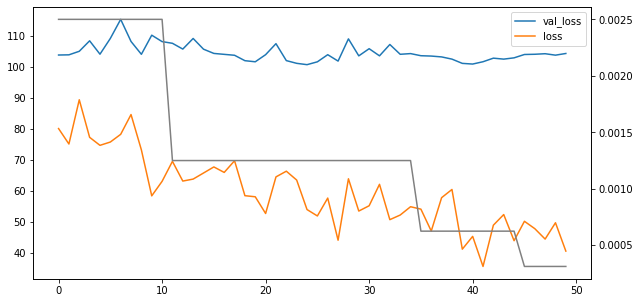

In [9]:
df_history = pandas.DataFrame(history.history)
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

In [10]:
# Realiza as previsões. Notar que a utilidade de prever trainX é nenhuma. Serve apenas para exibir no gráfico.

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

## Reescalonação dos dados para a escala original e cálculo dos RMSE de teste e treino.

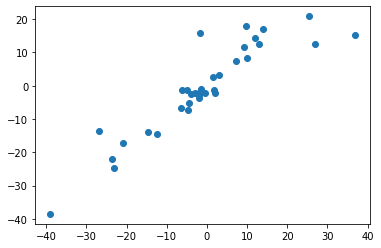

In [11]:
plt.scatter(trainY, trainPredict.ravel())

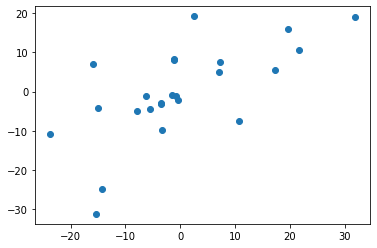

In [12]:
plt.scatter(testY, testPredict.ravel())

In [13]:
# Calcula os erros de previsão, quanto menor forem os valores, melhor predições serão feitas.

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.36 RMSE
Test Score: 10.21 RMSE


Imprime o gráfico da previsão (em vermelho)

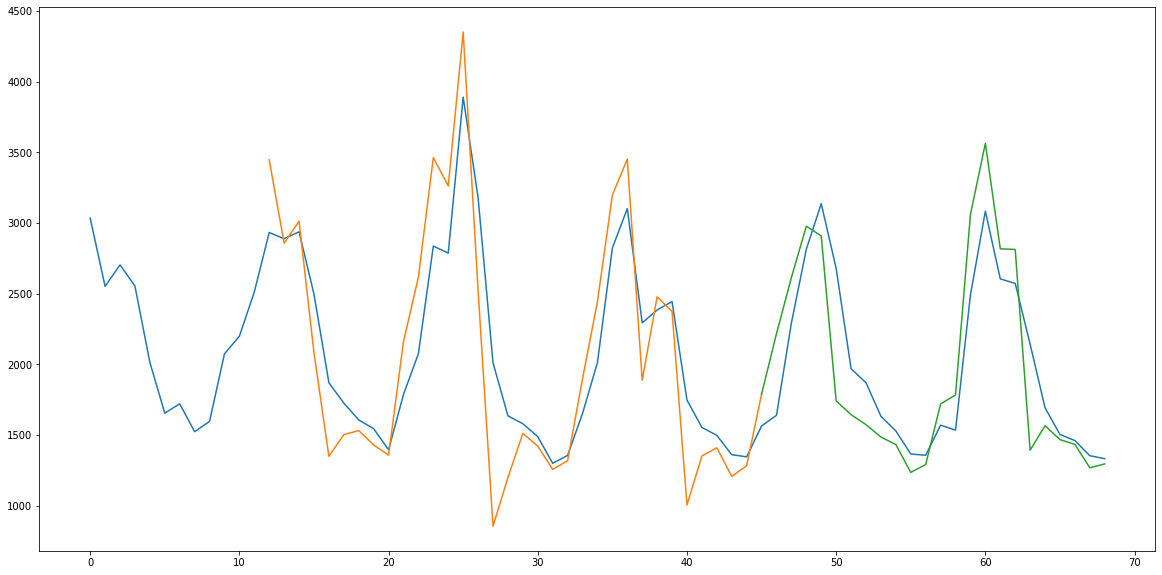

In [14]:
# shift train predictions for plotting
trainPredictPlot = (trainPredict.ravel() * 30) + dataset[look_back:len(trainPredict)+look_back, 0]

# shift test predictions for plotting
testPredictPlot = (testPredict.ravel() * 30) + dataset[len(trainPredict)+(look_back)-1:len(dataset), 0]

# plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(dataset)
plt.plot(look_back+numpy.arange(len(trainPredictPlot)), trainPredictPlot)
plt.plot(look_back+numpy.arange(len(testPredictPlot))+len(trainPredictPlot)-1, testPredictPlot)
plt.show()